In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session (engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date_str = session.query (Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_str

('2017-08-23',)

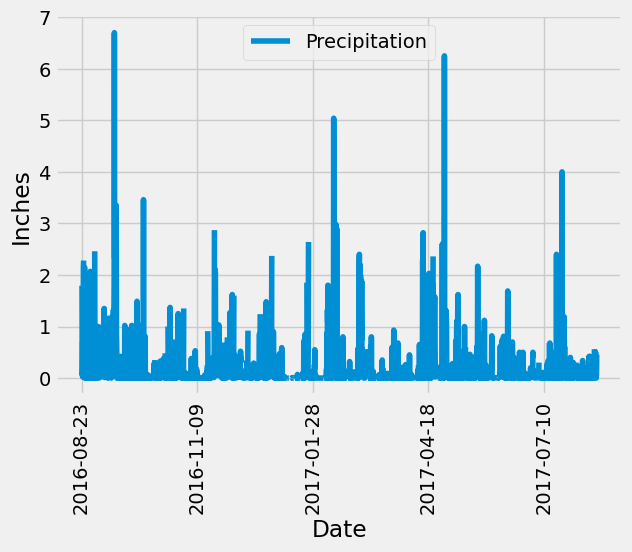

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime.strptime (most_recent_date_str[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta (days = 366)
#start_date.strftime ('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
from sqlalchemy import and_
prcp_scores = session.query (Measurement.date, Measurement.prcp).\
    filter (and_
            (Measurement.date >= start_date,
             Measurement.date <= end_date)
           )

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_scores_df = pd.DataFrame (prcp_scores, columns =['Date', 'Precipitation']) 

# Sort the dataframe by date
prcp_scores_df.sort_values (by = 'Date', inplace = True)
#prcp_scores_df
# Use Pandas Plotting with Matplotlib to plot the data
#prcp_scores_df.set_index ('Precipitation', inplace = True)
prcp_scores_df.plot (x = 'Date', y = 'Precipitation')
plt.tight_layout()
plt.xticks (rotation = 90)
plt.ylabel ("Inches")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pd.DataFrame (prcp_scores_df['Precipitation'].describe())
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query (func.count(Station.station)).all()
station_count

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
from sqlalchemy import desc
active_stations = session.query (Measurement.station, func.count(Measurement.station).label('row_count')).\
                    group_by(Measurement.station).order_by (desc ("row_count")).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
session.query (func.min (Measurement.tobs), func.max (Measurement.tobs), func.avg (Measurement.tobs)).\
  filter (Measurement.station == most_active_station).all()  

[(54.0, 85.0, 71.66378066378067)]

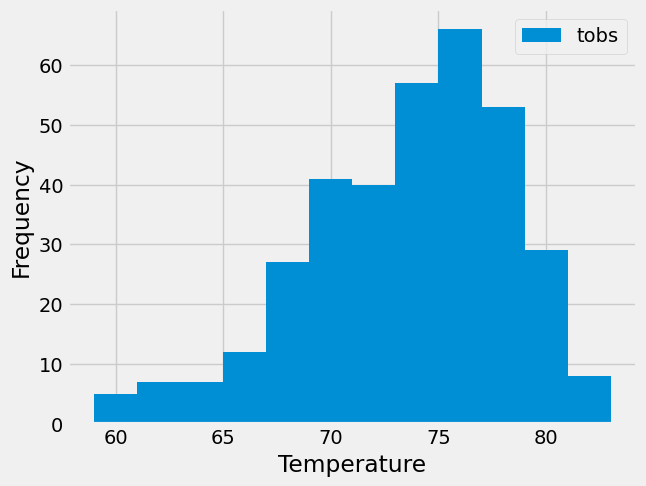

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date_temp_str = session.query (Measurement.date).order_by(Measurement.date.desc()).first()
end_date = dt.datetime.strptime (most_recent_date_temp_str[0], '%Y-%m-%d')
start_date = end_date - dt.timedelta (days = 366)
start_date
most_active_station_temp = session.query (Measurement.tobs).\
    filter (Measurement.station == most_active_station).\
    filter (Measurement.date >= start_date).\
    filter (Measurement.date <= end_date).all()

most_active_station_temp_df = pd.DataFrame (most_active_station_temp, columns =['Temperature'])
plt.hist (most_active_station_temp_df, bins = 12)
plt.tight_layout()
plt.xlabel ("Temperature")
plt.ylabel ("Frequency")
plt.legend (["tobs"], loc="upper right")
plt.show()


# Close Session

In [51]:
# Close Session
session.close()